Relaxation Dynamics
==========

There are many different methods which can be used to understand the dynamics of a system.
From short timescale events like structural relaxation,
to long timescale events including dynamics.
There are also important degrees of freedom in the rotations which have their own relaxtion timescales.


This is a collection of figures and analysis
for the understanding of relaxation over a series of variables.

All the simulation data is from a set of simulations stored on RDS
in the folder `data/simulations/trimer`.
This set of simulations were all run at a pressure of 13.50. 

## Setup

This imports the modules nessecary for running the code in the rest of this notebook
while also setting up some helper functions to make the rest of the analysis simpler.

In [1]:
import sys

import pandas as pd
import numpy as np
import altair as alt

sys.path.append('../src')
from figures import use_my_theme
use_my_theme()

alt.data_transformers.enable('json');

### Import Data

This reads all the data from disk,
creating a pandas DataFrame for both 
the dyanmics and the relaxation quantities.

In [2]:
data_file = "../data/analysis/dynamics.h5"

In [3]:
dynamics = pd.read_hdf(data_file, 'dynamics')
dynamics = dynamics.query("pressure == 13.50")
dynamics = dynamics.groupby(['temperature', 'time']).mean()
dynamics = dynamics.reset_index("temperature")
# Drop time == 0, messes up log log plots
dynamics.drop(0, inplace=True)
dynamics = dynamics.reset_index()

In [4]:
relaxations = pd.read_hdf(data_file, "relaxations")
relaxations = relaxations.query("pressure == 13.50")
relaxations['inv_temp'] = 1 / relaxations.temperature
relaxations['inv_diffusion'] = 1 / relaxations.diffusion_constant

The available temperatures for plotting are listed below.
To make the visualisations of time dependent properties less cluttered 
only a subset of the temperatures will be used for plotting.
For relaxation timescales all the temperatrues will be used.
This list of temperatures for plotting can be modified by changing the plot_temperatures variable.

In [5]:
np.sort(dynamics['temperature'].unique())

array([1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.6 , 1.8 , 2.  , 2.5 ])

Diffusion
--------

Generating the figures for diffusive relaxation of molecules. Lines are indications of fit, where $D t$ is the function that is defining the fit. The parameter `D` is then used as the diffusion constant in the following figure.

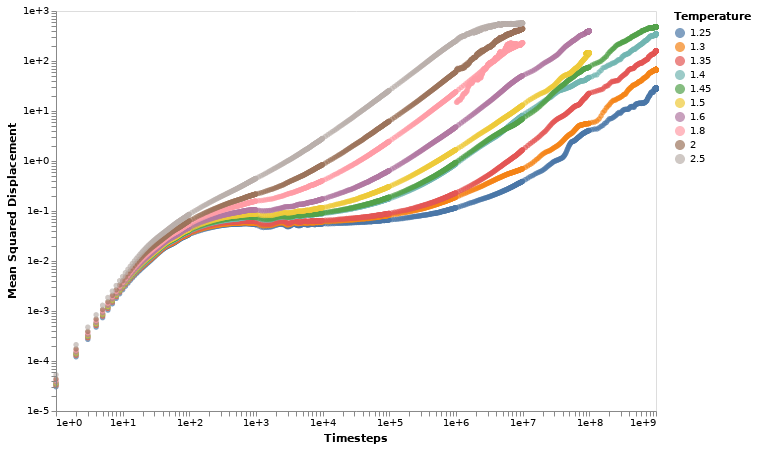

In [6]:
alt.Chart(dynamics).mark_point(filled=True).encode(
    alt.X("time", scale=alt.Scale(type='log'), axis=alt.Axis(title="Timesteps", format="e")),
    alt.Y("msd", scale=alt.Scale(type='log'), axis=alt.Axis(title="Mean Squared Displacement", format="e")),
    alt.Color("temperature:N", legend=alt.Legend(title="Temperature")),
)

Rotational Relaxation R2
--------------------

This is the second order relaxation function,
given by;
$$R_2(t) = \langle 2[ \hat{\mathbf{e}}(0) \cdot \hat{\mathbf{e}}(t)]^2 - 1 \rangle$$
where the value is averaged over all molecules and starting configurations. 

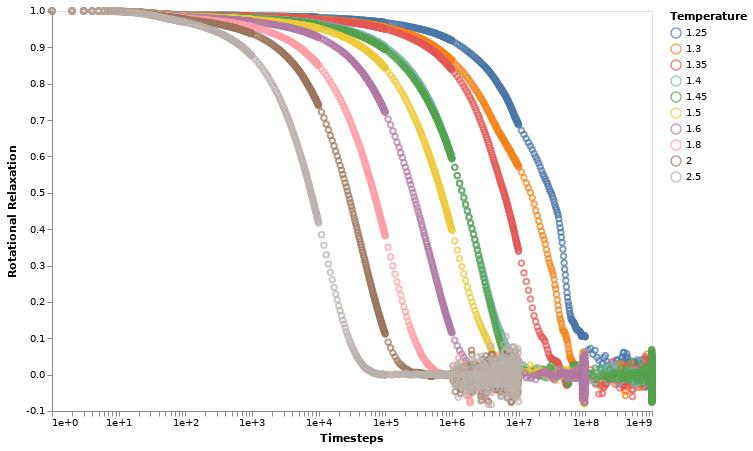

In [7]:
alt.Chart(dynamics).mark_point().encode(
    alt.X("time", scale=alt.Scale(type='log'), axis=alt.Axis(title="Timesteps", format="e")),
    alt.Y("rot2", axis=alt.Axis(title="Rotational Relaxation")),
    alt.Color("temperature:N", legend=alt.Legend(title="Temperature")),
).configure_axis(grid=False)

Structural Relaxation
--------------------

This is the fraction of particles which have moved a distance of 0.3 from their inital position.

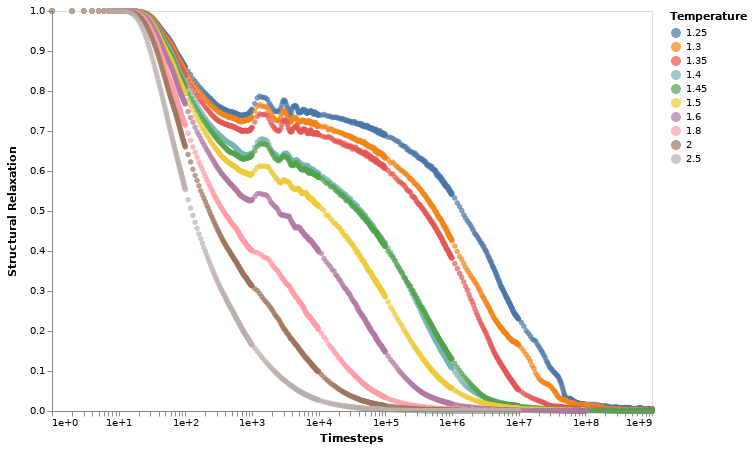

In [8]:
alt.Chart(dynamics).mark_point(filled=True).encode(
    alt.X("time", scale=alt.Scale(type='log'), axis=alt.Axis(title="Timesteps", format="e")),
    alt.Y("struct", axis=alt.Axis(title="Structural Relaxation")),
    alt.Color("temperature:N", legend=alt.Legend(title="Temperature")),
).configure_axis(grid=False)

Summary Values
========

The values calculated below summarise the above information,
providing a method of investigating temperature dependence of these properties. 

In [9]:
relaxations.diffusion_constant

8     2.765905e-08
9     6.734239e-08
10    1.509466e-07
12    4.105700e-07
13    7.817260e-07
14    1.156529e-06
15    4.594168e-06
17    2.671683e-05
18    5.921055e-05
19    2.585464e-04
Name: diffusion_constant, dtype: float64

In [10]:
relaxation_chart = alt.Chart(relaxations).mark_point().encode(
    alt.X("inv_temp:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="1/T"))
)

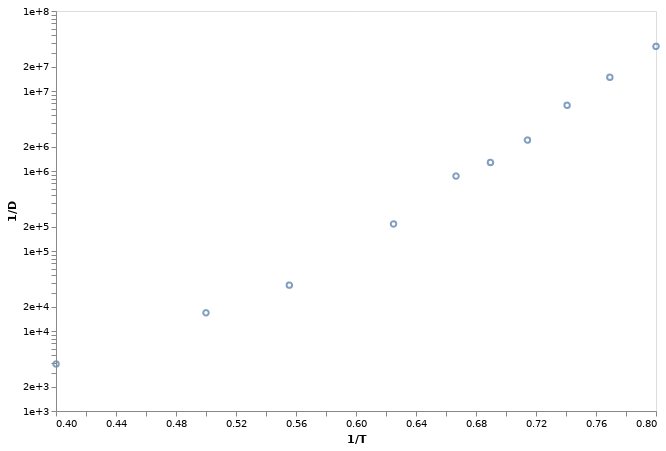

In [11]:
relaxation_chart.encode(
    alt.Y("inv_diffusion:Q", scale=alt.Scale(type='log'), axis=alt.Axis(title="1/D", format='e'))
)

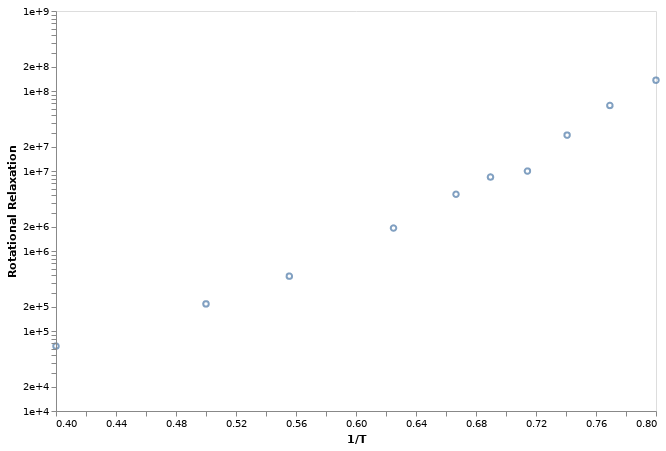

In [12]:
relaxation_chart.encode(
    alt.Y("tau_T2_mean", scale=alt.Scale(type='log'), axis=alt.Axis(title="Rotational Relaxation", format='e')),
)

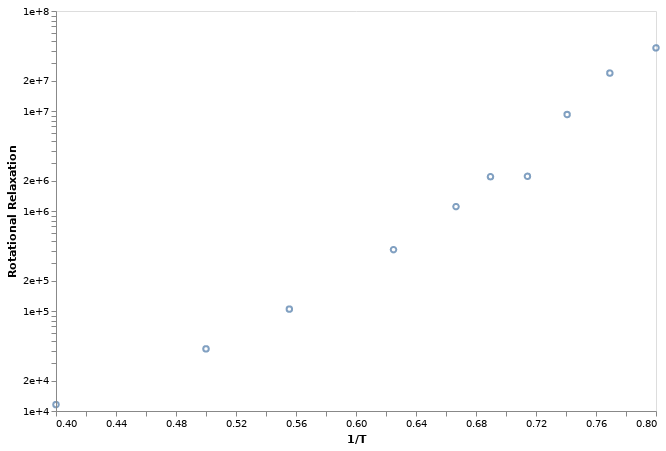

In [13]:
relaxation_chart.encode(
    alt.Y("tau_R2", scale=alt.Scale(type='log'), axis=alt.Axis(title="Rotational Relaxation", format='e')),
)

In [14]:
relaxations.columns

Index(['temperature', 'pressure', 'tau_D1_mean', 'tau_D1_hmean',
       'tau_D04_mean', 'tau_D04_hmean', 'tau_DL04_mean', 'tau_DL04_hmean',
       'tau_T2_mean', 'tau_T2_hmean', 'tau_T3_mean', 'tau_T3_hmean',
       'tau_T4_mean', 'tau_T4_hmean', 'max_alpha_time', 'tau_F',
       'max_gamma_time', 'diffusion_constant', 'tau_R1', 'tau_R2', 'tau_S',
       'inv_temp', 'inv_diffusion'],
      dtype='object')

In [15]:
values = pd.DataFrame({
    'Temperature': relaxations.temperature, 
    'r1r2': relaxations.tau_R1/relaxations.tau_R2,
    'Dr1T': relaxations.diffusion_constant*relaxations.tau_R1*relaxations.inv_temp,
    'Dr2T': relaxations.diffusion_constant*relaxations.tau_R2*relaxations.inv_temp,
    'DsT': relaxations.diffusion_constant*relaxations.tau_S*relaxations.inv_temp,
    'Dr1': relaxations.diffusion_constant*relaxations.tau_R1,
    'Dr2': relaxations.diffusion_constant*relaxations.tau_R2,
})

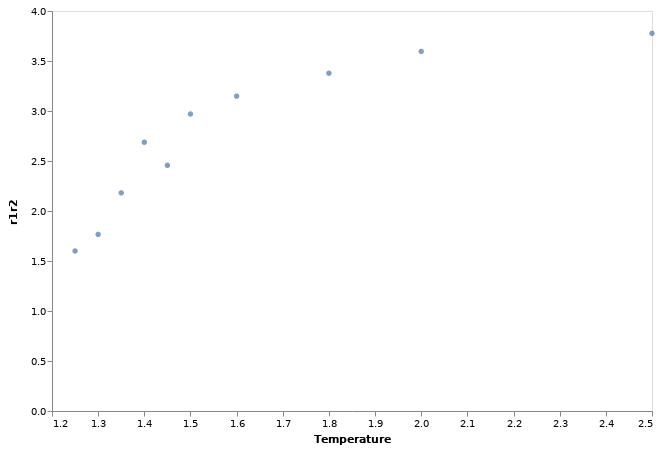

In [16]:
c = alt.Chart(values).mark_point(filled=True).encode(alt.X('Temperature', scale=alt.Scale(zero=False)))

c.encode(y='r1r2')